In [3]:
import grafiti as gf
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import squidpy as sq
from sklearn import metrics
import seaborn as sns
import pandas as pd
import torch
from sklearn.decomposition import PCA
import cellcharter as cc
import copy
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

datadir = "/data1/shahs3/users/mezallj1/data/dlpfc"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# All Slices

In [ ]:
ari_dic = {}

for filename in os.listdir(f'{datadir}/raw'):
    file_path = os.path.join(f'{datadir}/raw', filename)

    if os.path.isfile(file_path):
        
        adata = sc.read_h5ad(file_path)

        sq.gr.spatial_neighbors(adata,radius=50,coord_type='generic',delaunay=True) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

        gae = gf.ml.GAE(adata, layers=[50,50], lr=0.05)#, exponent=2, distance_scale=10)

        gae.train(100, update_interval=1, threshold=1e-3)

        gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

        gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

        gf.tl.find_motifs_gmm(adata,k=7)

        obs_df = adata.obs.dropna()

        ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])


# VGAE

In [97]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing

class GrafitiVAEEncoderLayer(MessagePassing):
    def __init__(self, in_channels, hidden_channels, latent_channels):
        super(GrafitiVAEEncoderLayer, self).__init__(aggr='add')
        self.lin_hidden = torch.nn.Linear(in_channels, hidden_channels)
        self.lin_mu = torch.nn.Linear(hidden_channels, latent_channels)
        self.lin_logvar = torch.nn.Linear(hidden_channels, latent_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype)
        return x_j / edge_attr.unsqueeze(-1)

    def forward(self, x, edge_index, edge_attr):
        hidden = F.relu(self.lin_hidden(x))
        hidden = self.propagate(edge_index, x=hidden, edge_attr=edge_attr)
        mu = self.lin_mu(hidden)
        logvar = self.lin_logvar(hidden)
        return mu, logvar

class GrafitiVAEDecoderLayer(MessagePassing):
    def __init__(self, latent_channels, hidden_channels, out_channels):
        super(GrafitiVAEDecoderLayer, self).__init__()
        self.lin_hidden = torch.nn.Linear(latent_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0)
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1)
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        hidden = F.relu(self.lin_hidden(x))
        aggr_out = self.propagate(edge_index, x=hidden, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features)
        return F.leaky_relu(transformed_features, negative_slope=0.01)

class GrafitiVAE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super(GrafitiVAE, self).__init__()
        self.encoder = GrafitiVAEEncoderLayer(in_dim, hidden_dim, latent_dim)
        self.decoder = GrafitiVAEDecoderLayer(latent_dim, hidden_dim, in_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, edge_index, edge_attr):
        mu, logvar = self.encoder(x, edge_index, edge_attr)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, edge_index, edge_attr), mu, logvar

class GAE(object):
    def __init__(self, adata, hidden_dim=32, latent_dim=16, lr=0.0001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu'):
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold is not None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        edges = adata.obsp["spatial_connectivities"].nonzero()

        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x, y] for x, y in zip(*edges)]
        if distance_scale is not None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0, distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1, 1)).reshape(1, -1)
            attrs = 1. / (np.array(attrs) ** exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=torch.from_numpy(attrs).to(self.device))
        self.adata = adata
        self.model = GrafitiVAE(data.num_features, hidden_dim, latent_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.losses = []
        self.val_losses = []
        self.global_epoch = 0
        self.data = data
        print("Ready to train!")

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = self.loss_fn(recon_x, x)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD * 0.1

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0

        for i in range(epochs):
            self.optimizer.zero_grad()
            recon_x, mu, logvar = self.model(self.data.x, self.data.edge_index, self.data.edge_attr)
            loss = self.loss_function(recon_x, self.data.x, mu, logvar)
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())

            if i % update_interval == 0:
                print(f"Epoch {self.global_epoch} ** iteration {i} ** Loss: {np.mean(self.losses[-update_interval:])}")

            # Early stopping condition
            if loss.item() < best_loss - threshold:
                best_loss = loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping due to no improvement over {patience} epochs.")
                break

            self.global_epoch += 1

        print("Training Complete.")

    def plot(self):
        import matplotlib.pyplot as plt
        plt.plot(self.losses, label='Training Loss')
        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss')
        plt.legend()
        plt.show()

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            mu, logvar = self.model.encoder(self.data.x, self.data.edge_index, self.data.edge_attr)
            z = self.model.reparameterize(mu, logvar)
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu


In [67]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [68]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [88]:
gae = GAE(adata, hidden_dim=50, latent_dim=50, lr=0.0001, device=device)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Ready to train!


In [89]:
gae.train(10000, update_interval=100, threshold=1e-1, patience=10)

Epoch 0 ** iteration 0 ** Loss: 324550.375
Epoch 100 ** iteration 100 ** Loss: 4159.988017883301
Epoch 200 ** iteration 200 ** Loss: 78.61449760437011
Epoch 300 ** iteration 300 ** Loss: 73.50864997863769
Epoch 400 ** iteration 400 ** Loss: 68.00847709655761
Epoch 500 ** iteration 500 ** Loss: 62.433130989074705
Epoch 600 ** iteration 600 ** Loss: 56.970457229614254
Epoch 700 ** iteration 700 ** Loss: 51.73721038818359
Epoch 800 ** iteration 800 ** Loss: 46.80611755371094
Epoch 900 ** iteration 900 ** Loss: 42.220364532470704
Epoch 1000 ** iteration 1000 ** Loss: 38.0017896270752
Epoch 1100 ** iteration 1100 ** Loss: 34.15724826812744
Epoch 1200 ** iteration 1200 ** Loss: 30.682071056365967
Epoch 1300 ** iteration 1300 ** Loss: 27.563669204711914
Epoch 1400 ** iteration 1400 ** Loss: 24.783675079345702
Epoch 1500 ** iteration 1500 ** Loss: 22.320439949035645
Epoch 1600 ** iteration 1600 ** Loss: 20.149455528259278
Epoch 1700 ** iteration 1700 ** Loss: 18.245196647644043
Epoch 1800 ** i

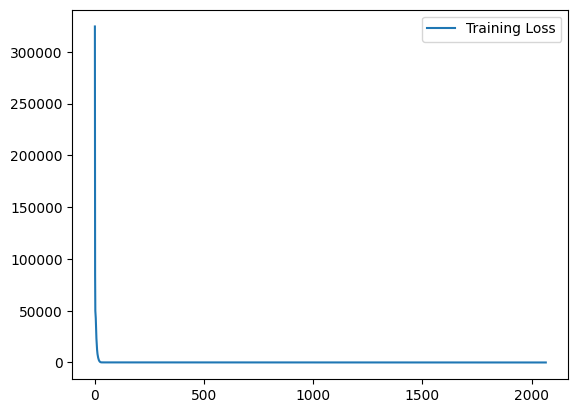

In [90]:
gae.plot()

In [91]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [92]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [93]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [94]:
obs_df = adata.obs.dropna()

In [95]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.00026468775610095615


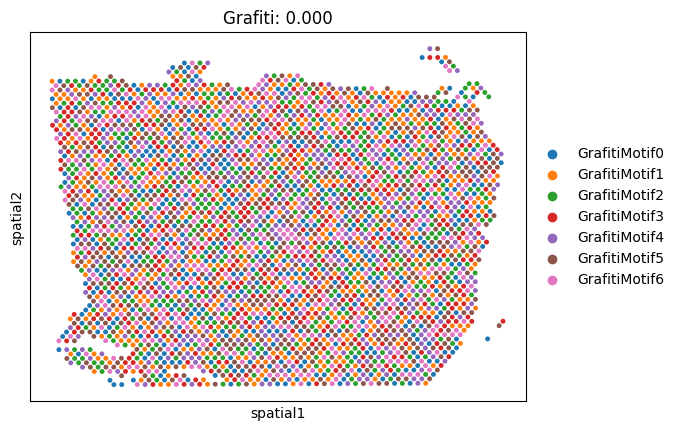

In [96]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# Contrastive Learning - DGI v2

In [36]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1)
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = s.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits
        
class GAE(object):

    def __init__(self, adata, layers=[10,10], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', alpha=10, beta=1, gamma=1, seed=42):
        seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        adj = adata.obsp["spatial_connectivities"]
        edges = adj.nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        self.graph_neigh = torch.from_numpy(adj.toarray()).type(torch.int64).to(self.device) + torch.eye(torch.from_numpy(adj.toarray()).type(torch.int64).shape[0]).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adam(self.gae.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.contrastive_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.gamma = gamma # Parameter for learning rate scheduler
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Preparing augmented data
            x_a = augmented_features(self.data.x) # Dynamic augmentation
            self.data.x_a = x_a

            # Encoding original and corrupted graph to latent space
            h = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            h_a = self.gae.encode(self.data.x_a, self.data.edge_index, self.data.edge_attr)

            # Summarizing latent embeddings of the original  graph to capture global context
            s = self.read(h, self.graph_neigh).to(self.device)
            s = self.sigm(s).to(self.device) # Normalize to 0-1 probabilities

            s_a = self.read(h_a, self.graph_neigh).to(self.device)
            s_a = self.sigm(s_a).to(self.device) # Normalize to 0-1 probabilities
            
            # Construction of logits (raw scores that represent the similarity between node embeddings and the summary vector)
            logits = self.disc(s, h, h_a)
            logits_a = self.disc(s_a, h_a, h)

            # Constrastive Loss
            labels = torch.cat([torch.ones(logits.shape[0], 1), torch.zeros(logits.shape[0], 1)], dim=1).to(logits.device)   
            contrastive_loss_1 = self.contrastive_loss(logits, labels)
            contrastive_loss_2 = self.contrastive_loss(logits_a, labels)
            
            # Reconstruction Loss
            reconstruction = self.gae.decode(h, self.data.edge_index, self.data.edge_attr)
            reconstruction_loss = self.reconstruction_loss(reconstruction, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * reconstruction_loss + self.beta * (contrastive_loss_1 + contrastive_loss_2)
            
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            #h = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            #hcpu = h.detach().cpu().numpy()
            #adata.obsm[encoding_key] = hcpu
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu

In [37]:
def augmented_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [38]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [39]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, zero_center=False, max_value=10)
#adata = adata[:,adata.var['highly_variable']]

In [40]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [122]:
gae = GAE(adata, layers=[50,50], lr=0.0001, device=device, alpha=5, beta=5, gamma=1)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [123]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 73.75669860839844
Epoch 100 ** iteration 100 ** Loss: 24.253375549316406
Epoch 200 ** iteration 200 ** Loss: 22.739131240844728
Epoch 300 ** iteration 300 ** Loss: 22.200815982818604
Epoch 400 ** iteration 400 ** Loss: 19.43525981903076
Epoch 500 ** iteration 500 ** Loss: 11.92393858909607
Early stopping due to no improvement over 10 epochs.
Training Complete.


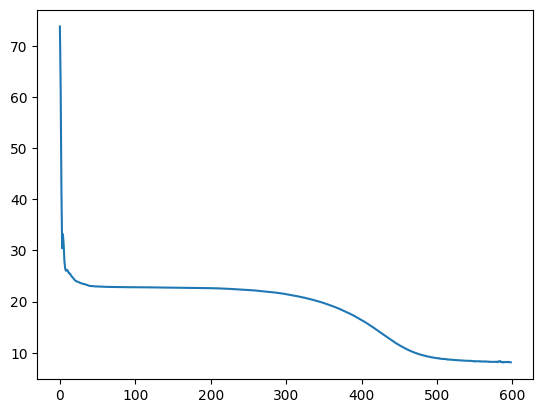

In [124]:
gae.plot()

In [125]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [126]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [127]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
  Iteration 70
  Iteration 80
  Iteration 90
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [128]:
obs_df = adata.obs.dropna()

In [129]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.37573543487454836


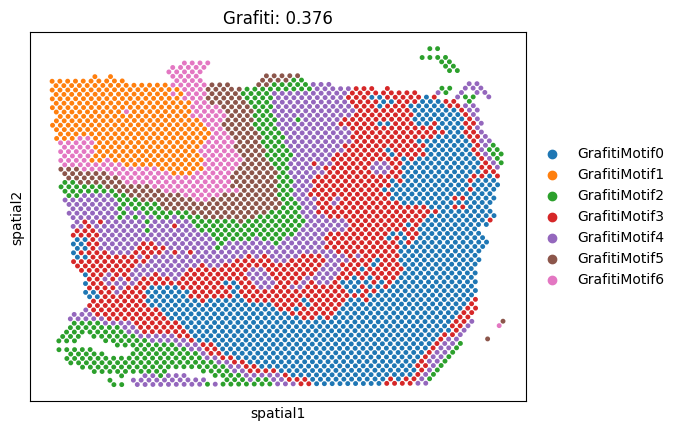

In [130]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# Contrastive Learning -  DGI

In [273]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1).to_dense()
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = s.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits
        
class GAE(object):

    def __init__(self, adata, layers=[10,10], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', alpha=10, beta=1, gamma=1, seed=42):
        seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        self.adj = adata.obsp["spatial_connectivities"]
        self.graph_neigh = sparse_mx_to_torch_sparse_tensor(self.adj + scipy.sparse.identity(self.adj.shape[0], format='csr'),self.device)
        edges = self.adj.nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adam(self.gae.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.contrastive_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.gamma = gamma # Parameter for learning rate scheduler
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Preparing augmented data
            x_a = augmented_features(self.data.x) # Dynamic augmentation
            self.data.x_a = x_a

            # Encoding original and corrupted graph to latent space
            h = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            h_a = self.gae.encode(self.data.x_a, self.data.edge_index, self.data.edge_attr)\

            self.h = h

            # Summarizing latent embeddings of the original  graph to capture global context
            s = self.read(h, self.graph_neigh).to(self.device)
            s = self.sigm(s).to(self.device) # Normalize to 0-1 probabilities

            self.s = s
            
            # Construction of logits (raw scores that represent the similarity between node embeddings and the summary vector)
            logits = self.disc(s, h, h_a)
            
            # Constrastive Loss
            labels = torch.cat([torch.ones(logits.shape[0], 1), torch.zeros(logits.shape[0], 1)], dim=1).to(logits.device)   
            contrastive_loss = self.contrastive_loss(logits, labels)
            
            # Reconstruction Loss
            reconstruction = self.gae.decode(h, self.data.edge_index, self.data.edge_attr)
            reconstruction_loss = self.reconstruction_loss(reconstruction, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * reconstruction_loss + self.beta * contrastive_loss
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            h = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            hcpu = h.detach().cpu().numpy()
            adata.obsm[encoding_key] = hcpu
            #zcpu = z.detach().cpu().numpy()
            #adata.obsm[encoding_key] = zcpu

In [274]:
def augmented_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def sparse_mx_to_torch_sparse_tensor(sparse_mx, device):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape).to(device)

In [275]:
def find_motifs(adata, resolution=0.5, cluster_key="grafiti_motif", neighbor_method="umap", n_neighbors=50, prefix="GrafitiMotif", encoding_key="X_grafiti",method="louvain",metric="euclidean",k=10,max_iter=10,use_weights=False,compute_neighbors=True, n_pcs=40):
    if compute_neighbors:
        sc.pp.neighbors(adata,use_rep=encoding_key,key_added="grafiti_neighbors", n_neighbors=n_neighbors, method=neighbor_method, metric=metric, n_pcs=n_pcs)
    if method == "louvain":
        sc.tl.louvain(adata,resolution=resolution,key_added=cluster_key,neighbors_key="grafiti_neighbors",use_weights=use_weights)
    elif method == "leiden":
        sc.tl.leiden(adata,resolution=resolution,key_added=cluster_key,neighbors_key="grafiti_neighbors",use_weights=use_weights)
    elif method == "gm":
        gm = GaussianMixture(n_components=k, random_state=0, max_iter=max_iter).fit(adata.obsm[encoding_key])
        adata.obs[cluster_key] = ["{}{}".format(prefix,x) for x in gm.predict(adata.obsm[encoding_key]).tolist()]
    else:
        raise ValueError("Method should be Louvain or Leiden.")
    adata.obs[cluster_key] = ["{}{}".format(prefix,x) for x in adata.obs[cluster_key].tolist()]

In [276]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [277]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, zero_center=False, max_value=10)
#adata = adata[:,adata.var['highly_variable']]

In [278]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [329]:
gae = GAE(adata, layers=[64], lr=0.0001, device=device, alpha=1, beta=10, gamma=.995)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [330]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 19.55253791809082
Epoch 100 ** iteration 100 ** Loss: 11.010956735610963
Early stopping due to no improvement over 10 epochs.
Training Complete.


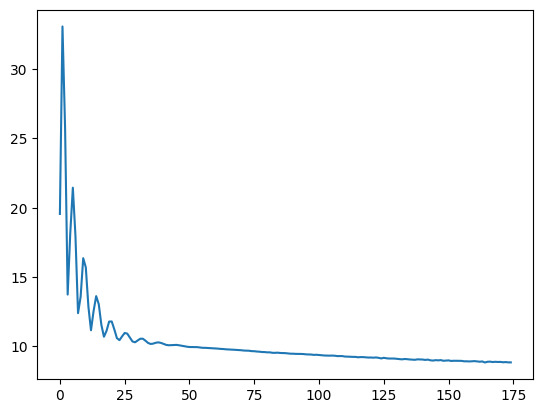

In [331]:
gae.plot()

In [332]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [333]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20, random_state=42) 
embedding = pca.fit_transform(adata.obsm['X_grafiti'].copy())
adata.obsm['X_grafiti_pca'] = embedding

In [334]:
#gf.tl.umap(adata, encoding_key='X_grafiti') # Embed grafiti latent space into umap latent space (2 dimensions)
gf.tl.umap(adata, encoding_key='X_grafiti_pca') # Embed grafiti latent space into umap latent space (2 dimensions)

In [335]:
#gf.tl.find_motifs_gmm(adata,k=7,embedding_key='X_grafiti')
gf.tl.find_motifs_gmm(adata,k=7,embedding_key='X_grafiti_pca')
#gf.tl.find_motifs(adata, resolution=0.05, cluster_key="grafiti_motif", neighbor_method="umap", n_neighbors=10, prefix="GrafitiMotif", encoding_key="X_grafiti",method="leiden",metric="euclidean",k=12,max_iter=10,use_weights=False, compute_neighbors=True)
#find_motifs(adata, resolution=0.05, cluster_key="grafiti_motif", neighbor_method="umap", n_neighbors=10, prefix="GrafitiMotif", encoding_key="X_grafiti",method="leiden",metric="euclidean",k=12,max_iter=10,use_weights=False, compute_neighbors=True)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [336]:
obs_df = adata.obs.dropna()

In [337]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.3525601956230439


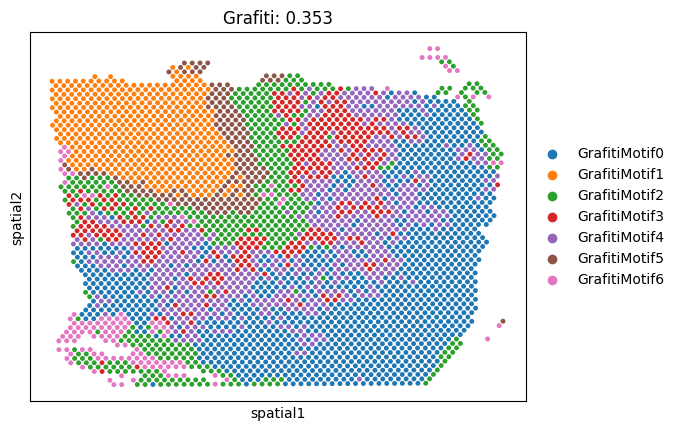

In [338]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

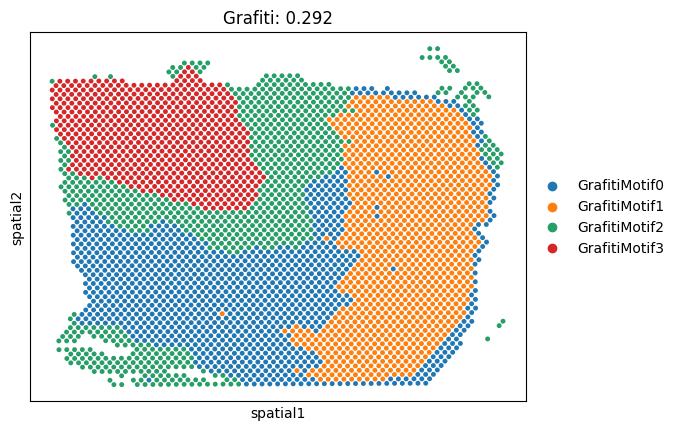

In [221]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# Contrastive Learning - GraphCL v3

In [4]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1).to_dense()
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return torch.mean(F.normalize(global_emb, p=2, dim=1),0)
        #return torch.mean(emb,0)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = torch.unsqueeze(s,0)
        s_x = s.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits
        
class GAE(object):

    def __init__(self, adata, layers=[50,50], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', aug_type='node', drop_rate=0.2, alpha=10, beta=1, gamma=1, seed=42):
        seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        self.adj = adata.obsp["spatial_connectivities"]
        edges = self.adj.nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adam(self.gae.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.contrastive_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.aug_type = aug_type
        self.drop_rate = drop_rate
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.gamma = gamma # Parameter for learning rate scheduler
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Preparing corrupt data
            self.data.xc = corrupt_features(self.data.x) # Dynamic augmentation
            
            # Preparing augmented data
            #self.data.x1, self.data.edge_index1, self.data.edge_attr1 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)
            #self.data.x2, self.data.edge_index2, self.data.edge_attr2 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)

            if self.aug_type == 'node':
                
                self.data.x1, self.data.edge_index1, self.data.edge_attr1 = aug_drop_node(self.data.x, self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate)
                self.data.x2, self.data.edge_index2, self.data.edge_attr2 = aug_drop_node(self.data.x, self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate)
            
            elif self.aug_type == 'edge':

                self.data.edge_index1, self.data.edge_attr1 = aug_edge_perturbation(self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate) # random drop edges
                self.data.edge_index2, self.data.edge_attr2 = aug_edge_perturbation(self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate) # random drop edges

                self.data.x1 = self.data.x
                self.data.x2 = self.data.x
                
            elif self.aug_type == 'mask':
            
                self.data.x1 = aug_random_mask(self.data.x,  drop_rate=self.drop_rate)
                self.data.x2 = aug_random_mask(self.data.x,  drop_rate=self.drop_rate)

                self.data.edge_index1, self.data.edge_attr1 = self.data.edge_index, self.data.edge_attr
                self.data.edge_index2, self.data.edge_attr2 = self.data.edge_index, self.data.edge_attr

            elif self.aug_type == 'subgraph':
                
                self.data.x1, self.data.edge_index1, self.data.edge_attr1 = aug_subgraph(self.data.x, self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate)
                self.data.x2, self.data.edge_index2, self.data.edge_attr2 = aug_subgraph(self.data.x, self.data.edge_index, self.data.edge_attr, drop_rate=self.drop_rate)
            
            
            # Encoding original, corrupted and augmented graphs to latent space
            
            h = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            hc = self.gae.encode(self.data.xc, self.data.edge_index, self.data.edge_attr)
            h1 = self.gae.encode(self.data.x1, self.data.edge_index1, self.data.edge_attr1)
            h2 = self.gae.encode(self.data.x2, self.data.edge_index2, self.data.edge_attr2)

            self.h=h
            self.h1=h1
            self.h2=h2


            # Summarizing latent embeddings of the two augmented graphs to capture local context
            s1 = self.read(h1, edge_index_to_sparse_adj_matrix(self.data.edge_index1, self.h1.shape[0], self.device)).to(self.device)
            s1 = self.sigm(s1).to(self.device) # Normalize to 0-1 probabilities
    
            s2 = self.read(h2, edge_index_to_sparse_adj_matrix(self.data.edge_index2, self.h2.shape[0], self.device)).to(self.device)
            s2 = self.sigm(s2).to(self.device) # Normalize to 0-1 probabilities

            self.s1 = s1
            self.s2 = s2

            #raise ValueError
            
            # Construction of logits (raw scores that represent the similarity between node embeddings and the summary vector)
            logits1 = self.disc(s1, h, hc)
            logits2 = self.disc(s2, h, hc)
            logits = logits1 + logits2
            
            # Constrastive Loss
            labels = torch.cat([torch.ones(logits.shape[0], 1), torch.zeros(logits.shape[0], 1)], dim=1).to(logits.device)   
            contrastive_loss = self.contrastive_loss(logits, labels)
            
            # Reconstruction Loss
            reconstruction = self.gae.decode(h, self.data.edge_index, self.data.edge_attr)
            reconstruction_loss = self.reconstruction_loss(reconstruction, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * reconstruction_loss + self.beta * contrastive_loss
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            #h = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            #hcpu = h.detach().cpu().numpy()
            #adata.obsm[encoding_key] = hcpu
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu

In [5]:
def corrupt_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def aug_random_mask(x, drop_rate=0.2):
    # Determine device
    device = x.device

    # Determine the number of features to mask
    num_features = x.size(1)
    
    # Generate a mask for the features to keep
    mask = torch.rand(num_features, device=device) > drop_rate

    # Create the augmented feature matrix by masking selected features
    aug_x = x.clone()
    aug_x[:, ~mask] = 0  # Mask the selected features by setting them to zero

    return aug_x

def aug_edge_perturbation(edge_index, edge_attr, drop_rate=0.2):
    
    # Determine device
    device =  edge_index.device
    
    # Generate mask for nodes to keep
    num_edges = edge_index.size(1)
    mask = torch.rand(num_edges, device=device) > drop_rate
    idx_nondrop = mask.nonzero(as_tuple=False).squeeze()

    # Create a mapping from old to new indices
    idx_map = -torch.ones(num_edges, dtype=torch.long, device=device)
    idx_map[idx_nondrop] = torch.arange(idx_nondrop.size(0), dtype=torch.long, device=device)

    # Filter edges and edge attributes based on the new mask
    mask_src = mask[edge_index[0]]
    mask_tgt = mask[edge_index[1]]
    valid_edges = mask_src & mask_tgt
    new_edge_index = idx_map[edge_index[:, valid_edges]]
    new_edge_attr = edge_attr[valid_edges]

    return new_edge_index, new_edge_attr


def aug_drop_node(x, edge_index, edge_attr, drop_rate=0.2):
    
    # Determine device
    device =  x.device
    
    # Generate mask for nodes to keep
    num_nodes = x.size(0)
    mask = torch.rand(num_nodes, device=device) > drop_rate
    idx_nondrop = mask.nonzero(as_tuple=False).squeeze()

    # Filter node features
    x_dropped = x[idx_nondrop]

    # Create a mapping from old to new indices
    idx_map = -torch.ones(num_nodes, dtype=torch.long, device=device)
    idx_map[idx_nondrop] = torch.arange(idx_nondrop.size(0), dtype=torch.long, device=device)

    # Filter edges and edge attributes based on the node mask
    mask_src = mask[edge_index[0]]
    mask_tgt = mask[edge_index[1]]
    valid_edges = mask_src & mask_tgt
    new_edge_index = idx_map[edge_index[:, valid_edges]]
    new_edge_attr = edge_attr[valid_edges]

    return x_dropped, new_edge_index, new_edge_attr


def aug_subgraph(x, edge_index, edge_attr, drop_rate=0.2):

    # Determine device
    device = x.device

    # Convert edge_index to adjacency matrix
    num_nodes = x.size(0)
    adj = edge_index_to_sparse_adj_matrix(edge_index, num_nodes, device)

    # Calculate the number of nodes to keep
    s_node_num = int(num_nodes * (1 - drop_rate))
    center_node_id = random.randint(0, num_nodes - 1)

    sub_node_id_list = [center_node_id]
    all_neighbor_list = []

    for i in range(s_node_num - 1):
        neighbors = adj[center_node_id].coalesce().indices()[0].tolist()
        all_neighbor_list += neighbors
        all_neighbor_list = list(set(all_neighbor_list))
        new_neighbor_list = [n for n in all_neighbor_list if n not in sub_node_id_list]
        if len(new_neighbor_list) != 0:
            new_node = random.sample(new_neighbor_list, 1)[0]
            sub_node_id_list.append(new_node)
        else:
            break

    # Generate the drop_node_list
    all_node_list = list(range(num_nodes))
    drop_node_list = sorted([i for i in all_node_list if i not in sub_node_id_list])

    # Filter the node features
    aug_x = torch.index_select(x, 0, torch.tensor(sub_node_id_list, device=device))

    # Update edge_index and edge_attr
    mask = torch.ones(num_nodes, dtype=torch.bool, device=device)
    mask[drop_node_list] = False

    edge_mask = mask[edge_index[0]] & mask[edge_index[1]]
    new_edge_index = edge_index[:, edge_mask]
    new_edge_attr = edge_attr[edge_mask]

    # Map old indices to new indices
    idx_map = -torch.ones(num_nodes, dtype=torch.long, device=device)
    idx_map[torch.tensor(sub_node_id_list, device=device)] = torch.arange(len(sub_node_id_list), device=device)

    new_edge_index = idx_map[new_edge_index]

    return aug_x, new_edge_index, new_edge_attr

def edge_index_to_sparse_adj_matrix(edge_index, max_num_nodes, device):
    
    # Create values tensor filled with ones (since it's an unweighted graph)
    values = torch.ones(edge_index.shape[1]).to(device)
    
    # Create the initial sparse adjacency matrix
    adjacency_matrix_sparse = torch.sparse.FloatTensor(edge_index, values, torch.Size([max_num_nodes, max_num_nodes]))
    
    # Add diagonal elements
    diag_indices = torch.arange(max_num_nodes, dtype=torch.long).to(device)
    diag_indices = torch.stack([diag_indices, diag_indices])  # Create pairs (i, i) for all nodes
    diag_values = torch.ones(max_num_nodes).to(device)  # Values of 1 for the diagonal
    
    # Combine initial edge_index with diagonal indices
    combined_indices = torch.cat([edge_index, diag_indices], dim=1)
    combined_values = torch.cat([values, diag_values])
    
    # Create the final sparse adjacency matrix with diagonal elements
    final_adjacency_matrix_sparse = torch.sparse.FloatTensor(combined_indices, combined_values, torch.Size([max_num_nodes, max_num_nodes]))
    
    return final_adjacency_matrix_sparse.to(device)

In [6]:
adata = sc.read_h5ad(f'{datadir}/raw/151507.h5ad')
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, zero_center=False, max_value=10)
#adata = adata[:,adata.var['highly_variable']]

In [119]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [120]:
gae = GAE(adata, layers=[50,50], lr=0.0001, device=device, aug_type='subgraph', alpha=5, beta=5, gamma=.995)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [121]:
gae.train(10000, update_interval=10, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 43.09571075439453
Epoch 10 ** iteration 10 ** Loss: 15.427308654785156
Epoch 20 ** iteration 20 ** Loss: 9.858421230316162
Epoch 30 ** iteration 30 ** Loss: 9.629385662078857
Epoch 40 ** iteration 40 ** Loss: 9.28093900680542
Epoch 50 ** iteration 50 ** Loss: 8.971467113494873
Epoch 60 ** iteration 60 ** Loss: 8.725888347625732
Epoch 70 ** iteration 70 ** Loss: 8.629147815704346
Epoch 80 ** iteration 80 ** Loss: 8.3385178565979
Epoch 90 ** iteration 90 ** Loss: 8.200475406646728
Epoch 100 ** iteration 100 ** Loss: 8.109521865844727
Epoch 110 ** iteration 110 ** Loss: 8.043727016448974
Epoch 120 ** iteration 120 ** Loss: 7.949590158462525
Epoch 130 ** iteration 130 ** Loss: 7.822994184494019
Epoch 140 ** iteration 140 ** Loss: 7.7628748416900635
Epoch 150 ** iteration 150 ** Loss: 7.710177993774414
Epoch 160 ** iteration 160 ** Loss: 7.568842077255249
Epoch 170 ** iteration 170 ** Loss: 7.5166267395019535
Epoch 180 ** iteration 180 ** Loss: 7.411941099166

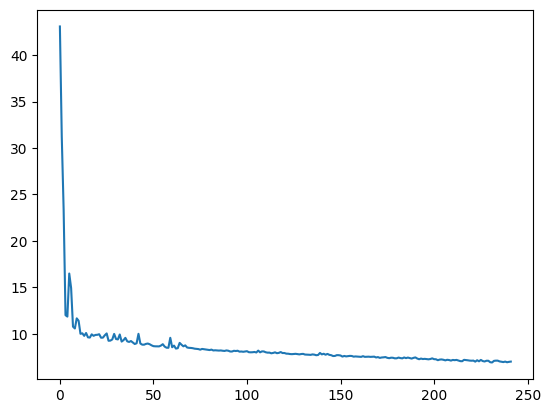

In [122]:
gae.plot()

In [123]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [124]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [125]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [126]:
obs_df = adata.obs.dropna()

In [127]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.4584099472100221


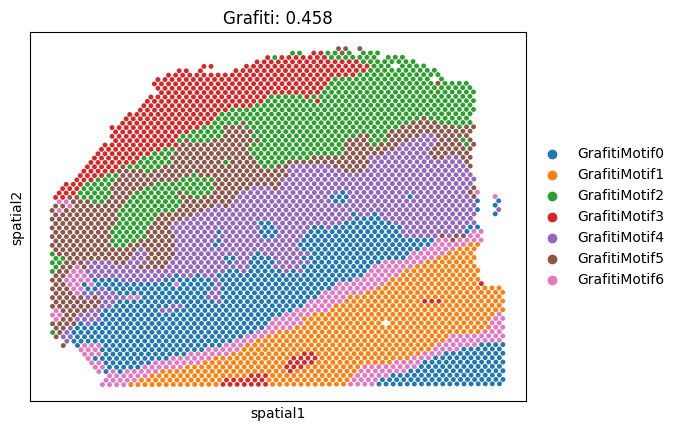

In [128]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

(array([5.787621e+06, 1.018940e+05, 2.287100e+04, 8.240000e+03,
        4.205000e+03, 2.885000e+03, 2.752000e+03, 2.753000e+03,
        2.756000e+03, 2.769000e+03, 2.516000e+03, 2.322000e+03,
        2.169000e+03, 1.904000e+03, 1.586000e+03, 1.487000e+03,
        1.559000e+03, 1.038000e+03, 9.100000e+02, 8.480000e+02,
        7.040000e+02, 5.650000e+02, 5.180000e+02, 4.870000e+02,
        3.590000e+02, 3.030000e+02, 2.590000e+02, 2.070000e+02,
        1.990000e+02, 1.530000e+02, 1.170000e+02, 1.100000e+02,
        7.200000e+01, 5.300000e+01, 3.500000e+01, 3.900000e+01,
        3.200000e+01, 1.900000e+01, 1.500000e+01, 8.000000e+00,
        5.000000e+00, 8.000000e+00, 6.000000e+00, 3.000000e+00,
        8.000000e+00, 3.000000e+00, 4.000000e+00, 1.000000e+00,
        1.000000e+00, 2.000000e+00]),
 array([  1.        ,   5.05999994,   9.11999989,  13.18000031,
         17.23999977,  21.29999924,  25.36000061,  29.42000008,
         33.47999954,  37.54000092,  41.59999847,  45.65999985,
  

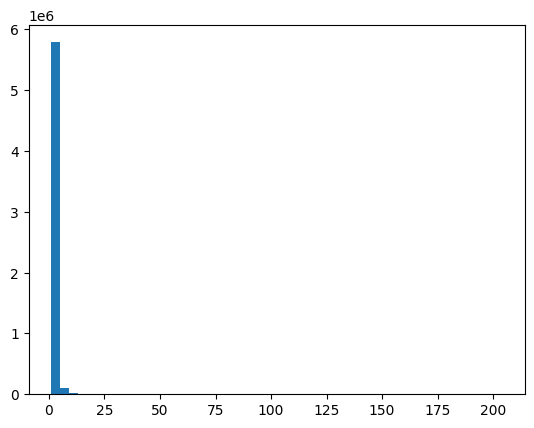

In [14]:
plt.hist(adata.X.toarray()[adata.X.toarray()>0],bins=50)

# Contrastive Learning - GraphCL v2

In [30]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.utils import to_dense_adj
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, emb, mask=None):
        vsum = torch.mm(mask, emb)
        row_sum = torch.sum(mask, 1)
        row_sum = row_sum.expand((vsum.shape[1], row_sum.shape[0])).T
        global_emb = vsum / row_sum 
          
        return F.normalize(global_emb, p=2, dim=1)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = s.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits
        
class GAE(object):

    def __init__(self, adata, layers=[50,50], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', alpha=10, beta=1, gamma=1, seed=42):
        seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        adj = adata.obsp["spatial_connectivities"]
        edges = adj.nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        self.graph_neigh = torch.from_numpy(adj.toarray()).type(torch.int64).to(self.device) + torch.eye(torch.from_numpy(adj.toarray()).type(torch.int64).shape[0]).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.optimizer = torch.optim.Adam(self.gae.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.contrastive_loss = nn.BCEWithLogitsLoss()
        self.reconstruction_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.gamma = gamma # Parameter for learning rate scheduler
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Preparing corrupt data
            self.data.xc = corrupt_features(self.data.x) # Dynamic augmentation
            
            # Preparing augmented data
            self.data.x1, self.data.edge_index1, self.data.edge_attr1 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)
            self.data.x2, self.data.edge_index2, self.data.edge_attr2 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)

            # Encoding original, corrupted and augmented graphs to latent space
            h = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            hc = self.gae.encode(self.data.xc, self.data.edge_index, self.data.edge_attr)
            h1 = self.gae.encode(self.data.x1, self.data.edge_index1, self.data.edge_attr1)
            h2 = self.gae.encode(self.data.x2, self.data.edge_index2, self.data.edge_attr2)

            self.h1 = h1

            # Summarizing latent embeddings of the two augmented graphs to capture local context
            s1 = self.read(h1, to_dense_adj(self.data.edge_index1)[0].fill_diagonal_(1)).to(self.device)
            s1 = self.sigm(s1).to(self.device) # Normalize to 0-1 probabilities
    
            s2 = self.read(h2, to_dense_adj(self.data.edge_index1)[0].fill_diagonal_(1)).to(self.device)
            s2 = self.sigm(s2).to(self.device) # Normalize to 0-1 probabilities
            
            # Construction of logits (raw scores that represent the similarity between node embeddings and the summary vector)
            logits1 = self.disc(s1, h, hc)
            logits2 = self.disc(s2, h, hc)
            logits = logits1 + logits2
            
            # Constrastive Loss
            labels = torch.cat([torch.ones(logits.shape[0], 1), torch.zeros(logits.shape[0], 1)], dim=1).to(logits.device)   
            contrastive_loss = self.contrastive_loss(logits, labels)
            
            # Reconstruction Loss
            reconstruction = self.gae.decode(h, self.data.edge_index, self.data.edge_attr)
            reconstruction_loss = self.reconstruction_loss(reconstruction, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * reconstruction_loss + self.beta * contrastive_loss
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            #h = self.gae.decode(z, self.data.edge_index, self.data.edge_attr)
            #hcpu = h.detach().cpu().numpy()
            #adata.obsm[encoding_key] = hcpu
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu

In [31]:
def corrupt_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def graph_augmentation(x, edge_index, edge_attr, mask_rate=0.2, perturb_rate=0.2, device='cpu'):
    x_aug = node_feature_masking(x, mask_rate, device)
    edge_index_aug, edge_attr_aug = edge_perturbation(edge_index, edge_attr, perturb_rate, device)
    return x_aug, edge_index_aug, edge_attr_aug

def node_feature_masking(x, mask_rate=0.2, device='cpu'):
    mask = (torch.rand(x.size(), device=device) > mask_rate).float()
    x_aug = x * mask
    return x_aug

def edge_perturbation(edge_index, edge_attr, perturb_rate=0.2, device='cpu'):
    num_edges = edge_index.size(1)
    perm = torch.randperm(num_edges, device=device)
    num_keep = int((1 - perturb_rate) * num_edges)
    edge_index_aug = edge_index[:, perm[:num_keep]]
    edge_attr_aug = edge_attr[perm[:num_keep]]
    return edge_index_aug, edge_attr_aug

In [45]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [46]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, zero_center=False, max_value=10)
#adata = adata[:,adata.var['highly_variable']]

In [47]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [48]:
gae = GAE(adata, layers=[50,50], lr=0.0001, device=device, alpha=5, beta=5, gamma=1)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [49]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 73.6380615234375
Epoch 100 ** iteration 100 ** Loss: 19.973346328735353
Epoch 200 ** iteration 200 ** Loss: 17.082231826782227
Epoch 300 ** iteration 300 ** Loss: 15.280647802352906
Epoch 400 ** iteration 400 ** Loss: 10.288589057922364
Epoch 500 ** iteration 500 ** Loss: 4.413316767215729
Early stopping due to no improvement over 10 epochs.
Training Complete.


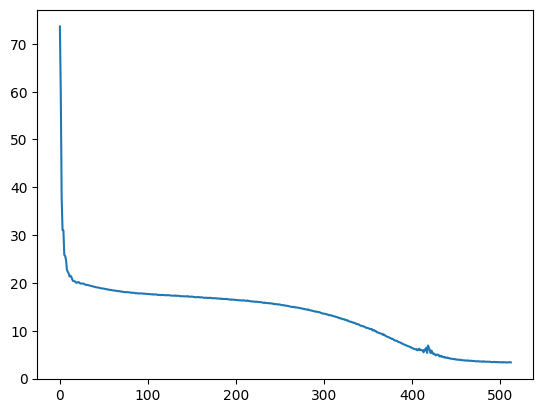

In [50]:
gae.plot()

In [51]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [52]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [53]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [54]:
obs_df = adata.obs.dropna()

In [55]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.3493363336323405


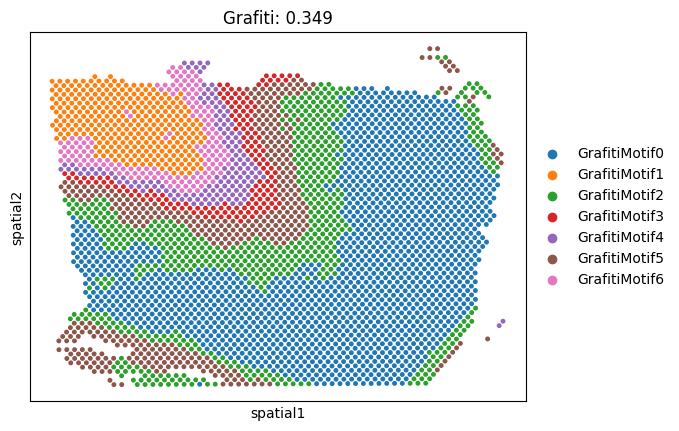

In [56]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# Contrastive Learning -  GraphCL

In [100]:
import scanpy as sc
import scipy.sparse
import numpy as np
import seaborn as sns
import umap
import torch.nn.functional as F
import torch
from torch import Tensor
import torch_scatter
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch_geometric.nn import models
from torch_geometric.nn import GraphSAGE
from torch_geometric.nn import aggr
from torch_geometric.nn import MessagePassing
from sklearn import preprocessing
import random

class GrafitiEncoderLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GrafitiEncoderLayer, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr):
        edge_attr = edge_attr.to(x_j.dtype) 
        return x_j / edge_attr.unsqueeze(-1) 

    def forward(self, x, edge_index, edge_attr):
        ret = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        ret = self.lin(ret) 
        return F.leaky_relu(ret, negative_slope=0.01)
    
class GrafitiDecoderLayer(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super(GrafitiDecoderLayer, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def message(self, x_j, edge_attr): 
        edge_attr = edge_attr.to(x_j.dtype)
        degree = x_j.size(0) 
        degree_normalized_message = x_j / edge_attr.unsqueeze(-1) 
        res = degree_normalized_message / degree
        return res

    def aggregate(self, inputs, index, dim_size=None):
        res = torch_scatter.scatter_mean(inputs, index, dim=0, dim_size=dim_size)
        return res

    def forward(self, x, edge_index, edge_attr):
        aggr_out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        transformed_features = x - aggr_out
        transformed_features = self.lin(transformed_features) 
        return F.leaky_relu(transformed_features, negative_slope=0.01)
    

class GrafitiEncoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[10,10]):
        super(GrafitiEncoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiEncoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiEncoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class GrafitiDecoderModule(torch.nn.Module):
    def __init__(self, in_dim, layers=[30,30]):
        super(GrafitiDecoderModule, self).__init__()
        self.layers = layers
        self.conv = nn.ModuleList()
        lhidden_dim = self.layers[0]
        self.conv.append(GrafitiDecoderLayer(in_dim, lhidden_dim))
        for hidden_dim in self.layers[1:]:
            self.conv.append(GrafitiDecoderLayer(lhidden_dim, hidden_dim))
            lhidden_dim = hidden_dim

    def forward(self, x, edge_index, edge_attr):
        for conv in self.conv:
            x = conv(x, edge_index=edge_index, edge_attr=edge_attr).relu()
        return x

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, h, mask):
        if mask is None:
            return torch.mean(h, 1)
        else:
            msk = torch.unsqueeze(mask, -1)
            return torch.sum(h * mask, 1) / torch.sum(mask)

class Discriminator(nn.Module):
    def __init__(self, n_hidden_layers, device):
        super(Discriminator, self).__init__()
        self.bilin = nn.Bilinear(n_hidden_layers, n_hidden_layers, 1).to(device)  # Bilinear layer to compute similarity

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            nn.init.xavier_uniform_(m.weight.data)  # Initialize weights
            if m.bias is not None:
                m.bias.data.fill_(0.0)  # Initialize bias

    def forward(self, s, h, h_a, s_bias1=None, s_bias2=None):
        s_x = torch.unsqueeze(s, 1) # Add an extra dimension to s
        s_x = s_x.expand_as(h)  # Expand s to match the size of h

        sc_1 = self.bilin(h, s_x)  # Compute similarity score for positive samples
        sc_2 = self.bilin(h_a, s_x)  # Compute similarity score for negative samples

        if s_bias1 is not None:
            sc_1 += s_bias1  # Add bias to positive scores
        if s_bias2 is not None:
            sc_2 += s_bias2  # Add bias to negative scores

        logits = torch.cat((sc_1, sc_2), 1)  # Concatenate scores to form logits

        return logits 

class ProjectionHead(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ProjectionHead, self).__init__()
        self.fc1 = torch.nn.Linear(in_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class GAE(object):

    def __init__(self, adata, layers=[10,10], lr=0.00001, distance_threshold=None, exponent=2, distance_scale=None, device='cpu', alpha=10, beta=1, gamma=1, temperature=0.5, seed=42):
        if seed is not None:
            seed_everything(seed)  # Seed everything for reproducibility
        self.lr = lr
        self.device = torch.device(device)
        print("Generating PyTorch Geometric Dataset...")
        if distance_threshold != None:
            distances = adata.obsp["spatial_distances"]
            connectiv = adata.obsp["spatial_connectivities"]
            rows, cols = distances.nonzero()
            for row, col in zip(rows, cols):
                if distances[row, col] > distance_threshold:
                    connectiv[row, col] = 0
            adata.obsp["spatial_connectivities"] = connectiv
        edges = adata.obsp["spatial_connectivities"].nonzero()

        # Check if adata.X is a scipy.sparse.csr_matrix
        if scipy.sparse.issparse(adata.X):
            x = torch.from_numpy(adata.X.toarray())
        else:
            x = torch.from_numpy(adata.X)

        x = x.float().to(self.device)
        e = torch.from_numpy(np.array(edges)).type(torch.int64).to(self.device)
        attrs = [adata.obsp["spatial_distances"][x,y] for x,y in zip(*edges)]
        if distance_scale!=None:
            scaler = preprocessing.MinMaxScaler(feature_range=(0,distance_scale))
            attrs = scaler.fit_transform(np.array(attrs).reshape(-1,1)).reshape(1,-1)
            attrs = 1. / (np.array(attrs)**exponent)
            attrs = attrs[0]
        else:
            attrs = np.array(attrs)
        data = Data(x=x, edge_index=e, edge_attr=attrs)
        self.adata = adata
        data.edge_attr = torch.from_numpy(data.edge_attr).to(self.device)
        self.encoder_layers = layers
        self.decoder_layers = list(reversed(layers[1:])) + [data.num_features]
        print("Setting up Model...")
        self.encoder = GrafitiEncoderModule(data.num_features,layers=self.encoder_layers).to(self.device)
        self.decoder = GrafitiDecoderModule(layers[-1],layers=self.decoder_layers).to(self.device)
        self.gae = models.GAE(encoder=self.encoder,decoder=self.decoder).to(self.device)
        self.projection_head = ProjectionHead(layers[-1], layers[-1], layers[-1]).to(self.device)
        self.optimizer = torch.optim.Adam(list(self.gae.parameters()) + list(self.projection_head.parameters()), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer,gamma)
        self.recon_loss = nn.MSELoss()
        self.losses = []
        self.global_epoch = 0
        self.data = data
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(layers[-1], self.device)
        self.alpha = alpha # Importance parameter for reconstruction loss
        self.beta = beta # Importance parameter for contrastive loss
        self.temperature = temperature # Contrastive Loss Parameter
        print("Ready to train!")

    def train(self, epochs, update_interval=5, threshold=0.001, patience=10):
        prev_loss = np.inf
        best_loss = np.inf
        patience_counter = 0 # Counter to track the number of epochs without improvement

        for i in range(epochs):
            self.optimizer.zero_grad()

            # Augment the graph
            x1, edge_index1, edge_attr1 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)
            x2, edge_index2, edge_attr2 = graph_augmentation(self.data.x, self.data.edge_index, self.data.edge_attr, device=self.device)

            # Forward pass
            h1 = self.gae.encode(x1, edge_index1, edge_attr1)
            h2 = self.gae.encode(x2, edge_index2, edge_attr2)
            z1 = self.projection_head(h1)
            z2 = self.projection_head(h2)

            # Compute contrastive loss
            cons_loss = contrastive_loss(z1, z2, self.temperature)

            # Reconstruction Loss
            h_original = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            recon = self.gae.decode(h_original, self.data.edge_index, self.data.edge_attr)
            recon_loss = self.recon_loss(recon, self.data.x)

            # Total Loss with the importance parameters
            loss = self.alpha * recon_loss + self.beta * cons_loss
            
            loss.backward()
            self.optimizer.step() 
            self.scheduler.step() # Step the learning rate scheduler
            self.losses.append(loss.item())
            if i % update_interval == 0:
                print("Epoch {} ** iteration {} ** Loss: {}".format(self.global_epoch, i, np.mean(self.losses[-update_interval:])))
            self.global_epoch += 1
            curr_loss = loss.item()

            # Check for improvement
            if curr_loss < best_loss - threshold:
                best_loss = curr_loss
                patience_counter = 0 # Reset the counter if there is an improvement
            else:
                patience_counter += 1

            # Early stopping condition
            if patience_counter >= patience:
                print("Early stopping due to no improvement over {} epochs.".format(patience))
                break

            prev_loss = curr_loss # Update previous loss

        print("Training Complete.")

    def __str__(self):
        fmt = "Pytorch Dataset\n\n"
        fmt += str(self.data) + "\n\n"
        fmt += "GAE Architecture\n\n"
        fmt += str(self.gae) + "\n"
        return fmt

    def plot(self):
        sns.lineplot(self.losses)

    def save(self, path):
        torch.save(self.gae.state_dict(), path)
    
    def load(self, path):
        state_dict = torch.load(path)
        self.gae.load_state_dict(state_dict)

    def load_embedding(self, adata, encoding_key="X_grafiti"):
        with torch.no_grad():
            z = self.gae.encode(self.data.x, self.data.edge_index, self.data.edge_attr)
            zcpu = z.detach().cpu().numpy()
            adata.obsm[encoding_key] = zcpu

In [101]:
def augmented_features(x):
    """Randomly permute the node features to create corrupted features."""
    perm = torch.randperm(x.size(0))
    return x[perm] 

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def node_feature_masking(x, mask_rate=0.1, device='cpu'):
    mask = torch.rand_like(x, device=device) > mask_rate
    x_aug = x * mask.float()
    return x_aug
def edge_perturbation(edge_index, edge_attr, perturb_rate=0.1, device='cpu'):
    num_edges = edge_index.size(1)
    num_perturb = int(num_edges * perturb_rate)
    perturb_indices = np.random.choice(num_edges, num_perturb, replace=False)
    edge_index_aug = edge_index[:, np.setdiff1d(np.arange(num_edges), perturb_indices)]
    edge_attr_aug = edge_attr[np.setdiff1d(np.arange(num_edges), perturb_indices)]
    return edge_index_aug, edge_attr_aug

def graph_augmentation(x, edge_index, edge_attr, mask_rate=0.1, perturb_rate=0.1, device='cpu'):
    x_aug = node_feature_masking(x, mask_rate, device)
    edge_index_aug, edge_attr_aug = edge_perturbation(edge_index, edge_attr, perturb_rate, device)
    return x_aug, edge_index_aug, edge_attr_aug

def contrastive_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=-1)
    z2 = F.normalize(z2, dim=-1)

    pos_sim = (z1 * z2).sum(dim=-1)
    neg_sim = torch.mm(z1, z2.t())

    pos_loss = -torch.log(torch.exp(pos_sim / temperature) / torch.exp(neg_sim / temperature).sum(dim=-1))
    return pos_loss.mean()


In [9]:
torch.tensor([1,2,3,4,5]) * (torch.rand(5)>0.2).float()

tensor([1., 2., 3., 4., 0.])

In [102]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [103]:
#Normalization
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.scale(adata, zero_center=False, max_value=10)
#adata[:, adata.var['highly_variable']]

In [104]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [114]:
gae = GAE(adata, layers=[50,50], lr=0.0001, device=device, alpha=0, beta=1, gamma=0.995)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [115]:
gae.train(10000, update_interval=100, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 8.135977745056152
Epoch 100 ** iteration 100 ** Loss: 7.073778705596924
Epoch 200 ** iteration 200 ** Loss: 6.597644486427307
Epoch 300 ** iteration 300 ** Loss: 6.484307556152344
Early stopping due to no improvement over 10 epochs.
Training Complete.


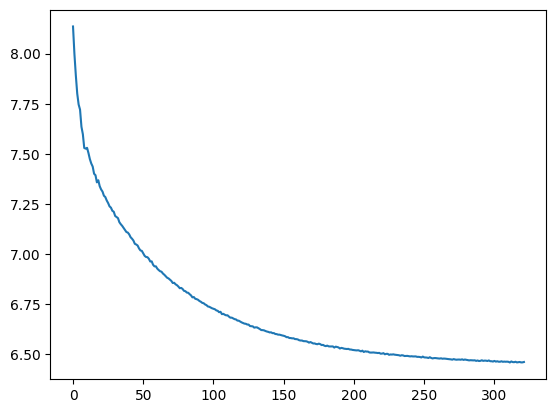

In [116]:
gae.plot()

In [117]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [118]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [119]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [120]:
obs_df = adata.obs.dropna()

In [121]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.342916380155062


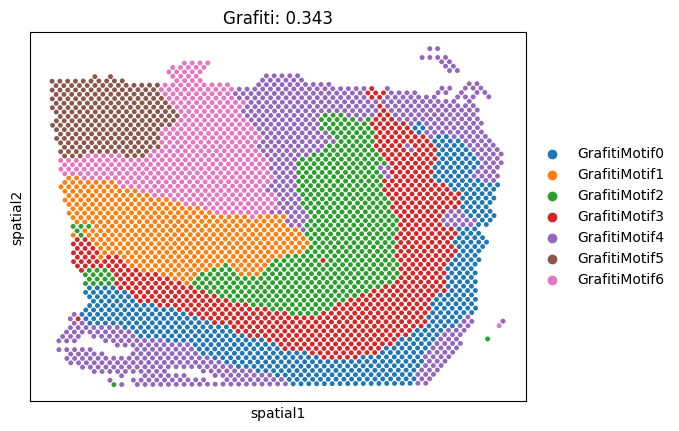

In [122]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# PCA

In [183]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [184]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [190]:
pca = PCA(n_components=20) 
pca_result = pca.fit_transform(adata.X.toarray())

In [116]:
gae = gf.ml.GAE(pca_result, layers=[10,10], lr=0.01, device=device)#, exponent=2, distance_scale=10)

NameError: name 'pca_result' is not defined

In [175]:
gae.train(10000, update_interval=10, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 5.0928473472595215
Epoch 10 ** iteration 10 ** Loss: 5.042810297012329
Epoch 20 ** iteration 20 ** Loss: 4.950309896469117
Epoch 30 ** iteration 30 ** Loss: 4.858608627319336
Epoch 40 ** iteration 40 ** Loss: 4.7677366733551025
Epoch 50 ** iteration 50 ** Loss: 4.676488161087036
Epoch 60 ** iteration 60 ** Loss: 4.584036922454834
Epoch 70 ** iteration 70 ** Loss: 4.492358064651489
Epoch 80 ** iteration 80 ** Loss: 4.404336261749267
Epoch 90 ** iteration 90 ** Loss: 4.321499156951904
Epoch 100 ** iteration 100 ** Loss: 4.244215297698974
Epoch 110 ** iteration 110 ** Loss: 4.172296190261841
Epoch 120 ** iteration 120 ** Loss: 4.10542049407959
Epoch 130 ** iteration 130 ** Loss: 4.043154907226563
Epoch 140 ** iteration 140 ** Loss: 3.98522572517395
Epoch 150 ** iteration 150 ** Loss: 3.9313246250152587
Epoch 160 ** iteration 160 ** Loss: 3.8812750339508058
Epoch 170 ** iteration 170 ** Loss: 3.8349125146865846
Epoch 180 ** iteration 180 ** Loss: 3.792000198

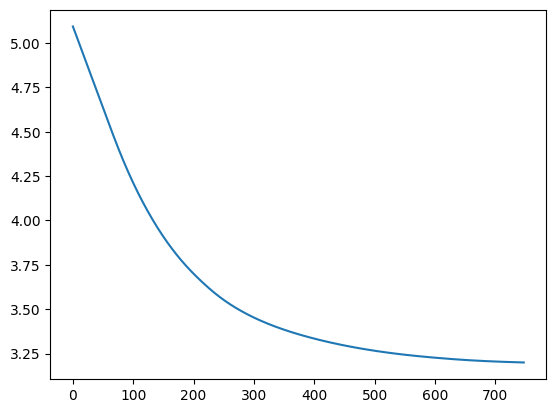

In [195]:
gae.plot()

In [177]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [178]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [179]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
  Iteration 10
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [180]:
obs_df = adata.obs.dropna()

In [181]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.30363645588053845


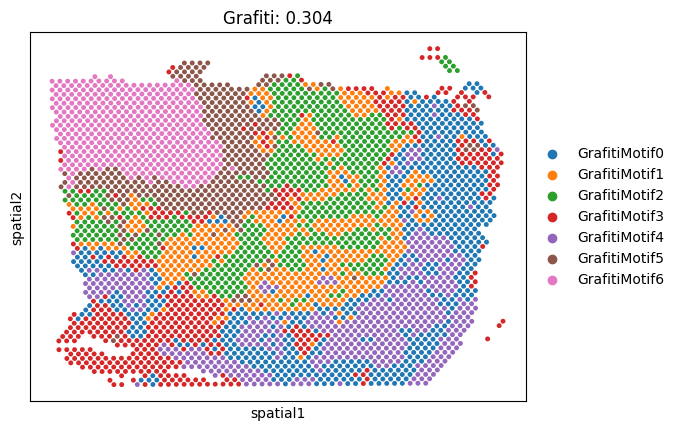

In [182]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

# Individual

In [3]:
adata = sc.read_h5ad(f'{datadir}/raw/151673.h5ad')
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
sq.gr.spatial_neighbors(adata,n_rings=1,coord_type='grid',delaunay=False) # Creates spatial_connectivities and spatial_distances in 'obsp' from spatial location (x,y) in 'obsm'

In [14]:
gae = gf.ml.GAE(adata, layers=[50,50], lr=0.0001, device=device)#, exponent=2, distance_scale=10)

Generating PyTorch Geometric Dataset...
Setting up Model...
Ready to train!


In [15]:
gae.train(10000, update_interval=10, threshold=1e-3, patience=10)

Epoch 0 ** iteration 0 ** Loss: 5.797666072845459
Epoch 10 ** iteration 10 ** Loss: 5.726813173294067
Epoch 20 ** iteration 20 ** Loss: 5.595728397369385
Epoch 30 ** iteration 30 ** Loss: 5.466162490844726
Epoch 40 ** iteration 40 ** Loss: 5.339515972137451
Epoch 50 ** iteration 50 ** Loss: 5.21665678024292
Epoch 60 ** iteration 60 ** Loss: 5.0985222339630125
Epoch 70 ** iteration 70 ** Loss: 4.985579204559326
Epoch 80 ** iteration 80 ** Loss: 4.878392696380615
Epoch 90 ** iteration 90 ** Loss: 4.777190208435059
Epoch 100 ** iteration 100 ** Loss: 4.6818756580352785
Epoch 110 ** iteration 110 ** Loss: 4.5923913478851315
Epoch 120 ** iteration 120 ** Loss: 4.50772066116333
Epoch 130 ** iteration 130 ** Loss: 4.425077629089356
Epoch 140 ** iteration 140 ** Loss: 4.345650577545166
Epoch 150 ** iteration 150 ** Loss: 4.273243522644043
Epoch 160 ** iteration 160 ** Loss: 4.206481790542602
Epoch 170 ** iteration 170 ** Loss: 4.144352912902832
Epoch 180 ** iteration 180 ** Loss: 4.08612112998

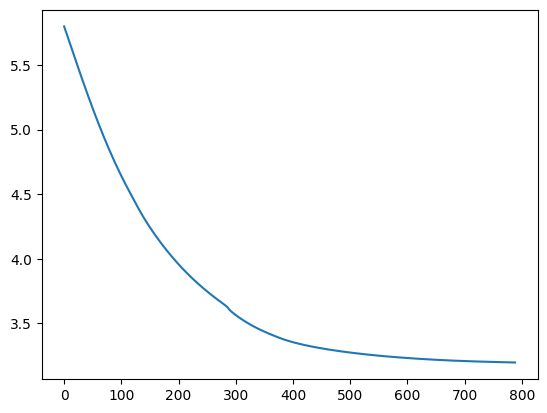

In [16]:
gae.plot()

In [17]:
gae.load_embedding(adata, encoding_key="X_grafiti") # Load features into the z latent space

In [18]:
gf.tl.umap(adata) # Embed grafiti latent space into umap latent space (2 dimensions)

In [19]:
gf.tl.find_motifs_gmm(adata,k=7)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='spherical', n_components=7, random_state=0,
                verbose=True)

In [20]:
obs_df = adata.obs.dropna()

In [21]:
ari = metrics.adjusted_rand_score(obs_df['grafiti_motif'], obs_df['Region'])
print(ari)

0.2907614636332483


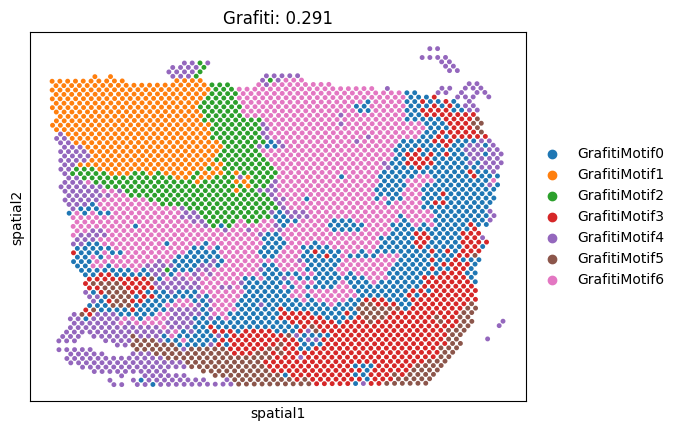

In [23]:
sc.pl.embedding(adata, basis='spatial', title = 'Grafiti: %.3f'%(ari), color ='grafiti_motif', s=50)

Text(0.5, 1.0, 'Spatial Distances DLPFC')

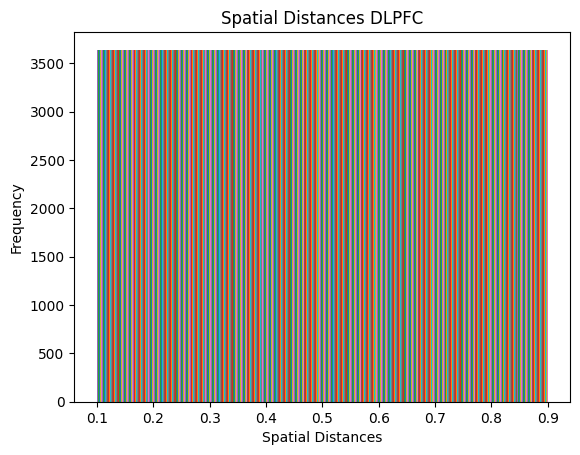

In [201]:
plt.hist(adata.obsp['spatial_distances'].toarray(), bins=1)
plt.xlabel('Spatial Distances')
plt.ylabel('Frequency')
plt.title('Spatial Distances DLPFC')